# Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import math
from scipy.integrate import odeint
from scipy.signal import find_peaks
import time as TimeLib
from tqdm import tqdm
import ast
import csv

# Problem 1: Compartmental models for disease spread

## 1.a) Outbreak:
At the beginning of an outbreak, the whole population is (in principle) susceptible to the disease $(S_0 ≈ (N = 1) )$. In the cell below, we set the constants of the disease $(\beta = 0.5$ and $\gamma = 0.1)$ as well as the initial state of the SIR model as $(S(0), I(0), R(0)) = (0.999,0.001 , 0)$. Then we solve the model for a time frame of 100 days after the start of the outbreak.

In [42]:
beta = 0.5
gamma = 0.1
initial_conditions = [0.999,0.001 , 0]
time = np.linspace(0, 100, 100)

#### Approximate solution:
When assuming $(S_0 ≈ (N = 1) )$, the model has an analytical solution, as we have shown in the report. The "approximated_solution" function, takes the current state and constants of the SIR model and gives the next steps values of S, I and R.
So the "approx_sol" array has all the values of the SIR compartments for all of the time steps.


In [43]:
alpha = np.sqrt( ( initial_conditions[0] * beta/gamma -1)**2 + 2 * initial_conditions[0]* initial_conditions[1]*(beta/gamma)**2  )
phi = np.emath.arctanh((initial_conditions[0] * beta/gamma -1)/alpha)

def approximated_solution(t,initials, beta, gamma,alpha,phi):
  app_R = (initials[0] * beta/gamma - 1+alpha * np.tanh(alpha*gamma*t/2-phi))/(initials[0] * (beta/gamma)**2)
  app_S = initials[0] * np.exp(-beta/gamma * app_R)
  app_I = 1 - app_R - app_S
  return app_S ,app_I , app_R

approx_sol = np.array([approximated_solution(t,initial_conditions,beta,gamma,alpha,phi) for t in time])


#### Numerical solution:
For solving this ODE system numerically, we used the "odient" from "scipy" library. The "solution" array is includes all the values of the SIR compartments for the whole simulation time.

In [44]:
def SIR(sir, time, beta, gamma):
    susceptible, infected , recovered = sir
    dsirdt = [-beta * susceptible * infected,
              beta * susceptible * infected - gamma * infected,
              gamma * infected]
    return dsirdt

solution = odeint(SIR, initial_conditions, time, args=(beta, gamma))

#### Deviations between approximations and numerical solutions

In the cell below, we find the point for each compartment, where the analytical approximation starts to deviate more than 1% from the numerical solution.



In [45]:
deviation_S = np.where(np.abs(solution[:, 0] - approx_sol[:, 0]) /solution[:, 0]  > 0.01)[0][0]
deviation_I = np.where(np.abs(solution[:, 1] - approx_sol[:, 1]) /solution[:, 1]  > 0.01)[0][0]
deviation_R = np.where(np.abs(solution[:, 2] - approx_sol[:, 2]) /solution[:, 2]  > 0.01)[0][0]

<ipython-input-45-3102f248b4c6>:3: RuntimeWarning: invalid value encountered in divide
  deviation_R = np.where(np.abs(solution[:, 2] - approx_sol[:, 2]) /solution[:, 2]  > 0.01)[0][0]


#### plotting the results
Here we plot the analytical approximation and the numerical solution for the SIR model in 100 days after the outbreak. The star marks show the deviations of more than 1%. This shows that the approximate solution is accurate for the first 15 days, but not further.


(-0.001, 100.001)

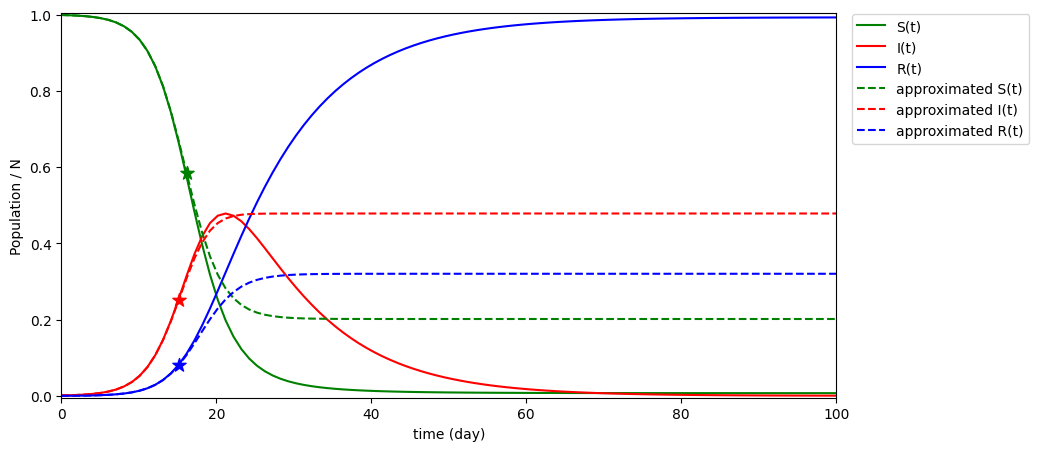

In [46]:
deviation = np.abs(solution[:, 0] - approx_sol[:, 0])

fig, ax = plt.subplots(1,1,figsize = (10,5))
ax.plot(time, solution[:, 0], 'g', label='S(t)')
ax.plot(time, solution[:, 1], 'r', label='I(t)')
ax.plot(time, solution[:, 2], 'b', label='R(t)')
ax.plot(time, approx_sol[:, 0], 'g',ls='--', label='approximated S(t)')
ax.plot(time, approx_sol[:, 1], 'r',ls='--', label='approximated I(t)')
ax.plot(time, approx_sol[:, 2], 'b',ls='--', label='approximated R(t)')
ax.scatter(time[deviation_S],approx_sol[deviation_S, 0] , marker="*", c = 'g' , s = 100)
ax.scatter(time[deviation_I],approx_sol[deviation_I, 1] , marker="*", c = 'r' , s = 100)
ax.scatter(time[deviation_R],approx_sol[deviation_R, 2] , marker="*", c = 'b' , s = 100)


ax.legend(loc=(1.02,0.66))
ax.set_xlabel('time (day)')
ax.set_ylabel('Population / N')
ax.set_ylim(-0.005 ,1.005)
ax.set_xlim(-0.001 ,100.001)



## 1.b) Endemic state:
To compare the endemic state of the SIR and SIRS models, we start with the initial state of $(S(0), I(0), R(0)) = (0.999,0.001 , 0)$ and solve the equations for a longer time (e.g. 5 years). To investigate the influence of the $R_0 = \beta / \gamma $  on the endemic state, we fixed the value of the $\gamma$ at 0.1 and change the value of $\beta$ in a range that gives $R_0$ values between 0 and 5.

In [47]:
T = 5 * 365
R0_list = np.linspace(0, 5, 100)
initial_conditions = [0.999,0.001,0]
time = np.arange(T)
gamma = 0.1
beta_list = R0_list * gamma

### SIR model:
We solve the SIR model for a time frame of 5 years with differnet values of $R_0$. The "final_resutls_SIR" array inclued the endemic state of $(S,I,R)$ for each set of constants $(\beta, \gamma)$. Then we plot the results. As we can see, regardless of the $R_0$ value, the $I$ in the endemic state is always zero.

(-0.001, 5.001)

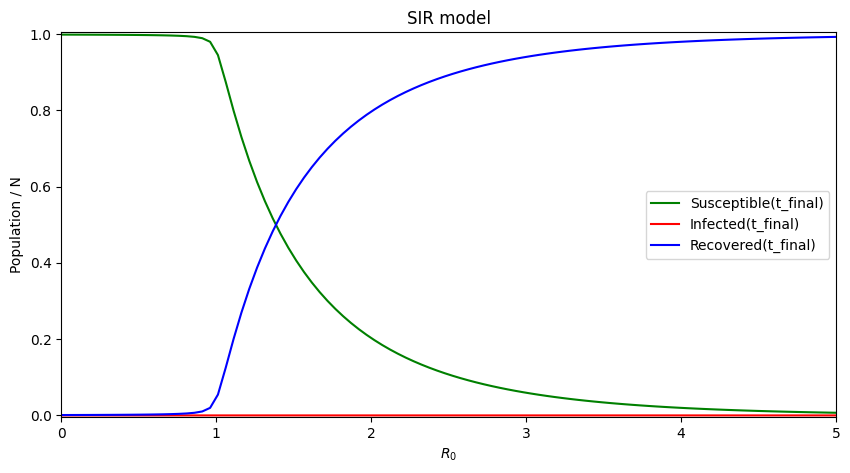

In [48]:
final_resutls_SIR = []
for beta in beta_list:
  solution = odeint(SIR, initial_conditions, time, args=(beta, gamma))
  final_resutls_SIR.append([solution[-1,0],
                        solution[-1,1],
                        solution[-1,2]])
final_resutls_SIR = np.array(final_resutls_SIR)

####################plotting#############################

fig, ax = plt.subplots(1,1,figsize = (10,5))
ax.plot(R0_list, final_resutls_SIR[:, 0], 'g', label='Susceptible(t_final)')
ax.plot(R0_list, final_resutls_SIR[:, 1], 'r', label='Infected(t_final)')
ax.plot(R0_list, final_resutls_SIR[:,2], 'b', label='Recovered(t_final)')
ax.legend(loc='best')
ax.set_xlabel('$R_0$')
ax.set_ylabel('Population / N')
ax.set_title("SIR model")
ax.set_ylim(-0.005 ,1.005)
ax.set_xlim(-0.001 ,max(R0_list)+ 0.001)


### SIRS model:
we do the same with the SIRS model. For this, we need to define a wanning immunity rate $\nu = 0.01$. The "final_resutls_SIRS" array inclued the final state of the SIRS model after 5 years, for different $R_0$ values. Then we plot the results. As it is demonstrated, in the SIRS model, the value of $I$ in the endemic state is bigger than zero, if $R_0 > 1$.

(-0.001, 5.001)

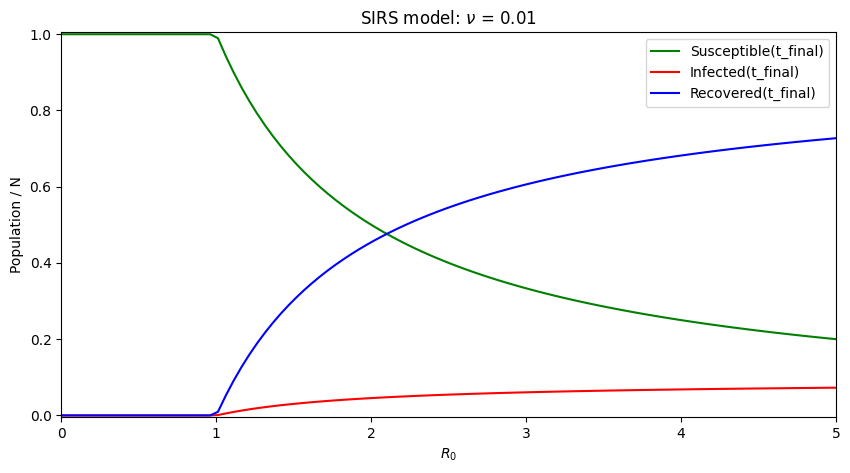

In [49]:
def SIRS(sirs, time, beta, gamma , nu):
    susceptible, infected , recovered = sirs
    dsirsdt = [-beta * susceptible * infected + nu * recovered,
              beta * susceptible * infected  -  gamma * infected,
              gamma * infected - nu * recovered]
    return dsirsdt
nu = 0.01
final_resutls_SIRS = []
for beta in beta_list:
  solution = odeint(SIRS, initial_conditions, time, args=(beta, gamma , nu))
  final_resutls_SIRS.append([solution[-1,0],
                        solution[-1,1],
                        solution[-1,2]])
final_resutls_SIRS = np.array(final_resutls_SIRS)

###################plotting##########################
fig, ax = plt.subplots(1,1,figsize = (10,5))
ax.plot(R0_list, final_resutls_SIRS[:, 0], 'g', label='Susceptible(t_final)')
ax.plot(R0_list, final_resutls_SIRS[:, 1], 'r', label='Infected(t_final)')
ax.plot(R0_list, final_resutls_SIRS[:,2], 'b', label='Recovered(t_final)')
ax.legend(loc='best')
ax.set_xlabel('$R_0$')
ax.set_ylabel('Population / N')
ax.set_title("SIRS model: $\u03BD$ = "+ str(nu))
ax.set_ylim(-0.005 ,1.005)
ax.set_xlim(-0.001 ,max(R0_list)+ 0.001)

### The influence of $\nu$:
 To investigate the influence of the wanning immunitz rate of the endemic state, we run the above simulation with 4 different values of $\nu$ and plot the results below.

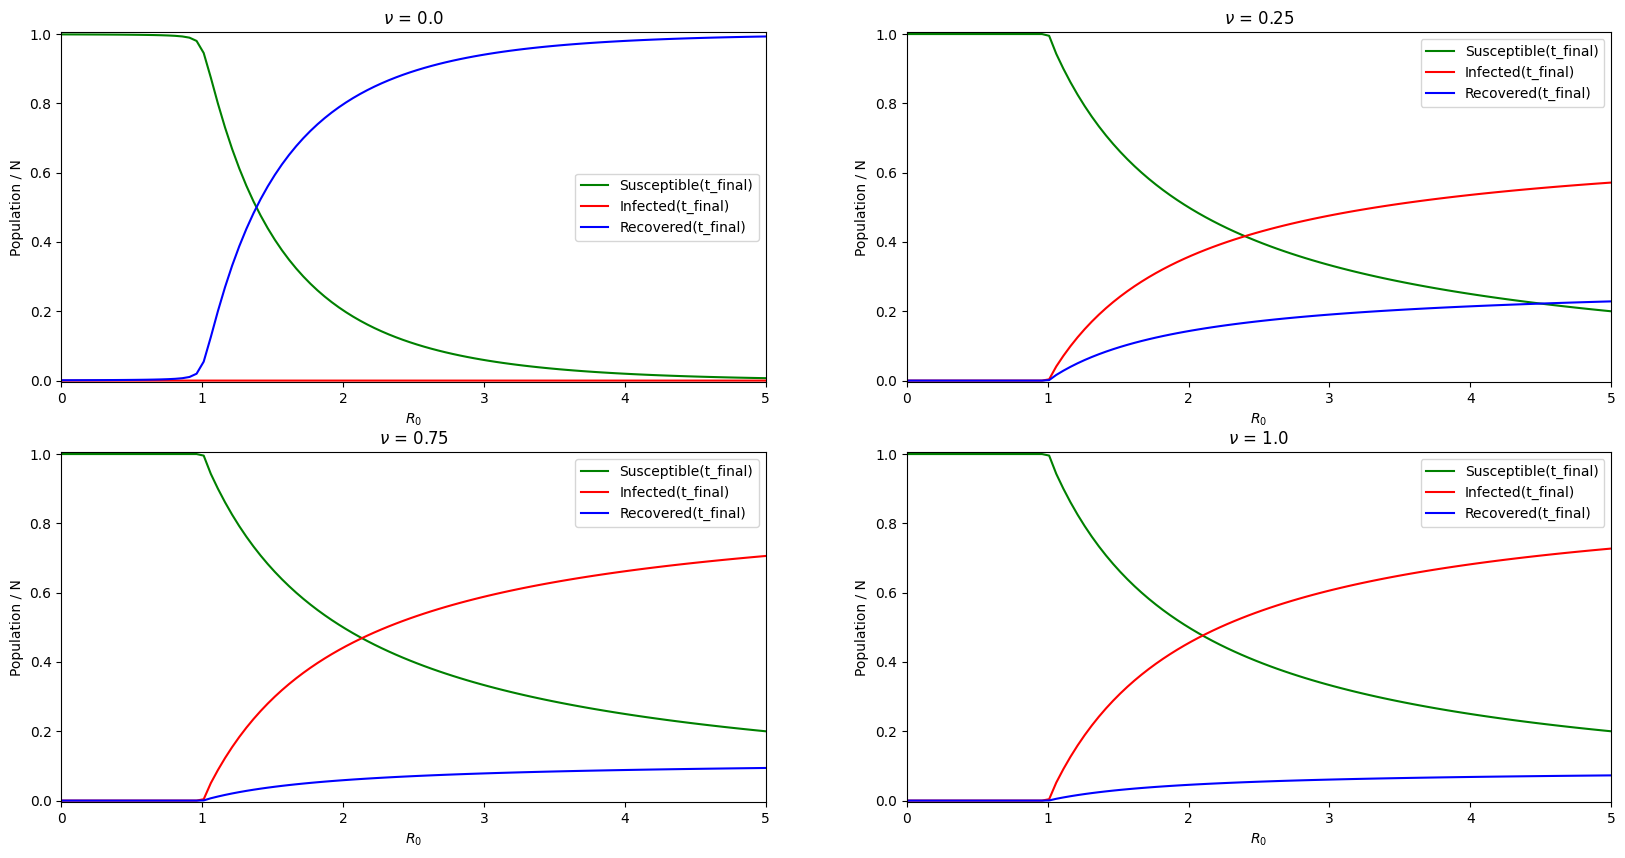

In [50]:
fig, ax = plt.subplots(2, 2 , figsize = (20,10))
NU_list = [0.0 , 0.25 , 0.75,1.0]
k = 0
for i in range(2):
  for j in range(2):
    res = []
    for beta in beta_list:
      solution = odeint(SIRS, initial_conditions, time, args=(beta, gamma , NU_list[k]))
      res.append([solution[-1,0],
                            solution[-1,1],
                            solution[-1,2]])
    res = np.array(res)
    ax[i,j].plot(R0_list, res[:, 0], 'g', label='Susceptible(t_final)')
    ax[i,j].plot(R0_list, res[:, 1], 'r', label='Infected(t_final)')
    ax[i,j].plot(R0_list, res[:,2], 'b', label='Recovered(t_final)')
    ax[i,j].legend(loc='best')
    ax[i,j].set_title("$\u03BD$ = "+str(NU_list[k]))
    ax[i,j].set_xlabel('$R_0$')
    ax[i,j].set_ylabel('Population / N')
    k += 1
    ax[i,j].set_ylim(-0.005 ,1.005)
    ax[i,j].set_xlim(-0.001 ,max(R0_list)+ 0.001)

### Bifurcation diagram:
Now we want to plot the bifurcation diagram of the SIRS model. For this we can apply two approches: The analytical and numerical solutions. The "analitical_final_I" function gets the constants of the model and returns the $I$ in the endemic solution, based on the analytical solution of the fixed points of the SIRS model. Then we use this function as well as the "SIRS" function to find the $I_f$ for different values of $R_0$ and plot the results.




(0.0, 5.001)

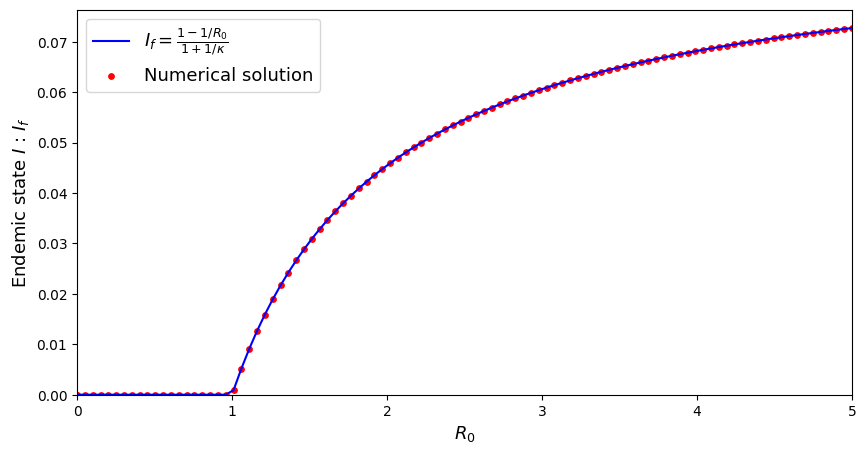

In [51]:
######### Analitical solution ###############
def analitical_final_I(beta, gamma,nu):
  kappa = nu / gamma
  r0 = beta / gamma
  if r0 > 1:
    return (1-1/r0)/(1+1/kappa)
  else:
    return 0
#############calculating I-f from analitical and numerical approches#################
peak_I = []
Analy_I_f = []
for beta in beta_list:
  solution = odeint(SIRS, initial_conditions, time, args=(beta, gamma , nu))
  Analy_I_f.append(analitical_final_I(beta, gamma , nu))
  peak_I.append(solution[-1,1])
peak_I = np.array(peak_I)

############plotting###################
fig, ax = plt.subplots(1,1,figsize = (10,5))

for i in range(len(beta_list)):
  ax.scatter(R0_list[i] , peak_I[i],s = 15, c ='r')
ax.plot(R0_list, Analy_I_f, c ='b',label="$I_f = \\frac{1-1/R_0}{1+1/\u03BA}$")
ax.scatter(R0_list[0] , peak_I[0],s = 15, c ='r',label="Numerical solution")
ax.set_xlabel('$R_0$',fontsize = 13)
ax.set_ylabel('Endemic state $I$ : $I_f$',fontsize = 13)
ax.legend(loc='best',fontsize = 13)
ax.set_ylim(0.0 ,)
ax.set_xlim(0.00 ,max(R0_list)+ 0.001)

## 1.c) n-casecade immunity loss
Now we want to investigate the effect of gradsually losing the immunity instead of the exponential lost. For this purpose, we define n_casecade $R$ compartment. To compare the results we solve the model for $n = $ 4, 2 and 1. The "n4_SIRS" and "n2_SIRS" functions, solve the ODEs for the $n = 4$ and $n = 2$ casecades models, respectively ( the $ n = 1 $ model is the same as the simple SIRS model). We use these three functions to find the $I_f$ for a range of $R_0$ values and plot the results.

(0.0, 5.001)

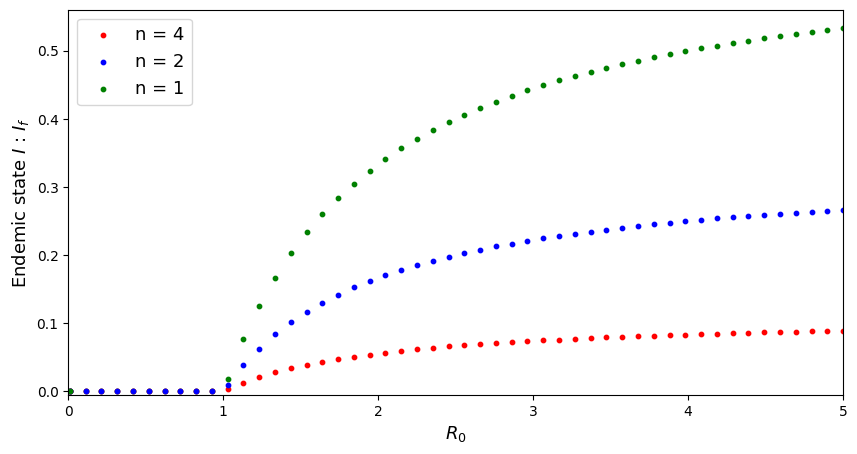

In [52]:
######### constants and initial conditions ##############
gamma = 0.1
nu = 0.2
T = 10*365
time = np.arange(T)
R0_list = np.linspace(0.01, 5, 50)
beta_list = R0_list * gamma

initial_conditions_n4_cas = [0.999, 0.001,0,0,0,0] ### initial conditions for the n = 4 casecades model
initial_conditions_n2_cas = [0.999, 0.001,0,0] ### initial conditions for the n = 2 casecades model
initial_conditions_n1_cas = [0.999, 0.001,0] ### initial conditions for the n = 1 casecades model
##################defininf the n = 4 and n = 2 casecades-SIRS models ##################################
def n4_SIRS(sirs4, time, beta, gamma , nu):
    susceptible, infected , recovered_1, recovered_2, recovered_3, recovered_4= sirs4
    dsirsdt4 = [-beta * susceptible * infected  + nu/4 * recovered_4,
              beta * susceptible * infected  -  gamma * infected,
              gamma * infected - nu/4 * recovered_1,
              nu/4 * recovered_1 - nu/4 * recovered_2,
               nu/4 * recovered_2 - nu/4 * recovered_3,
               nu/4 * recovered_3 - nu/4 * recovered_4 ,]
    return dsirsdt4

def n2_SIRS(sirs2, time, beta, gamma , nu):
    susceptible, infected , recovered_1, recovered_2 = sirs2
    dsirsdt2 = [-beta * susceptible * infected + nu/2 * recovered_2,
              beta * susceptible * infected -  gamma * infected,
              gamma * infected - nu/2 * recovered_1,
              nu/2 * recovered_1 - nu/2 * recovered_2,]
    return dsirsdt2


peak_I_4 = []
peak_I_2 = []
peak_I = []
for beta in beta_list:
  solution_n_4 = odeint(n4_SIRS, initial_conditions_n4_cas, time, args=(beta, gamma , nu))
  solution_n_2 = odeint(n2_SIRS, initial_conditions_n2_cas, time, args=(beta, gamma , nu))
  solution_n_1 = odeint(SIRS, initial_conditions_n1_cas, time, args=(beta, gamma , nu))
  peak_I_4.append(solution_n_4[-1,1])
  peak_I_2.append(solution_n_2[-1,1])
  peak_I.append(solution_n_1[-1,1])
peak_I_4 = np.array(peak_I_4)
peak_I_2 = np.array(peak_I_2)
peak_I = np.array(peak_I)

################# plotting ##############################
fig, ax = plt.subplots(1,1,figsize = (10,5))

for i in range(len(beta_list)):
  ax.scatter(R0_list[i] , peak_I[i],s = 10, c ='g')
  ax.scatter(R0_list[i] , peak_I_4[i],s = 10, c ='r')
  ax.scatter(R0_list[i] , peak_I_2[i],s = 10, c ='b')

ax.scatter(R0_list[0] , peak_I_4[0],s = 10, c ='r',label="n = 4")
ax.scatter(R0_list[0] , peak_I_2[0],s = 10, c ='b',label="n = 2")
ax.scatter(R0_list[0] , peak_I[0],s = 10, c ='g',label="n = 1")

ax.set_xlabel('$R_0$',fontsize = 13)
ax.set_ylabel('Endemic state $I$ : $I_f$',fontsize = 13)
ax.legend(loc='best',fontsize = 13)
ax.set_ylim(-0.005 ,)
ax.set_xlim(0.00 ,max(R0_list)+ 0.001)

# Problem 2: Self-regulation in disease spread
In this problem we are going to solve the SIRSm model by adding the mitigation to the SIRS model.
The constants and initial conditions used for this problem are defined in the cell below (the same values as in the Table 1 of the problem sheet, except for the $a = 0$).

In [4]:
####constants
beta = 0.5
gamma = 0.1
nu = 0.01
tau = 25
a_GAMMA = 0
w_GAMMA = 2*np.pi/360
h_thr = pow(10,-3)
m_max = 0.7
epsilon = 1/4000
######initializations
initial_conditions_IDE = [(1-h_thr),h_thr,0 ] ###[S(0),I(0),R(0)]
years = 5
time = np.arange(years*365)

## 2.a)   Integrodifferential equation
To solve the integrtodifferential equations we use the "np.trapz" for the integral part and the "odient" for the ODEs. The "IDE_SIRSm" function takes the models constants and initial conditions and solve the integrodifferential equations and return the solutions.
To measure the performance of this function, we try to solve a SIRSm model for 5 years and repeat it for 100 time and calculate the average time that this function takes to solve these integrodifferential equations. At the end, as an example, we plot one of the solutions.

Run time: 2.640362124443054+- 1.2356502384947299 seconds


(-0.001, 1915.2)

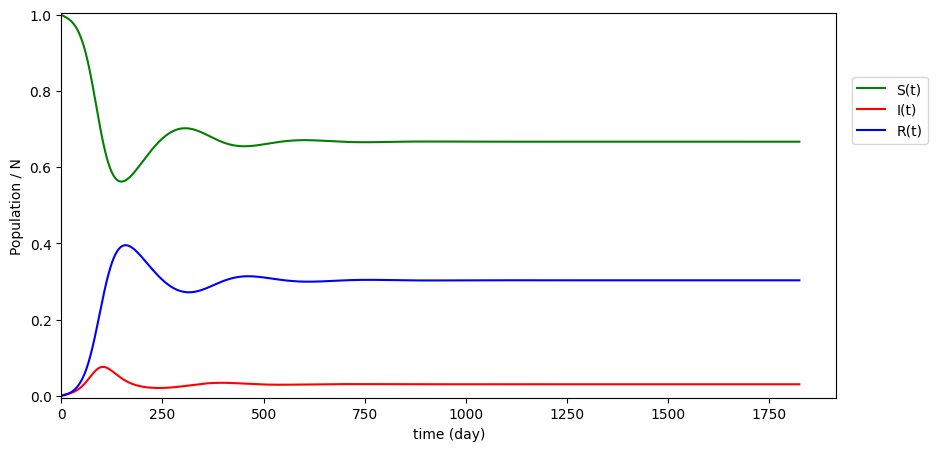

In [22]:
initial_conditions_IDE = [(1-h_thr),h_thr,0 ] ###[S(0),I(0),R(0)]

def delay_Kernel(t_k):
  return t_k * np.exp(-t_k/tau)/(tau**2)

def m(h_m):
  return m_max - (m_max/h_thr * epsilon * np.log10(1+np.exp(1/epsilon*(h_thr - h_m))))

infected_list = []

def IDE_SIRSm(sir, time, beta = 0.5, gamma = 0.1 , nu = 0.01,tau = 25,m_max = 0.7 , h_th = pow(10,-3), epsilon = 1/4000 ,a_GAMMA =0 , w_GAMMA = 2*np.pi/360 ):
  susceptible, infected , recovered   = sir
  infected_list.append(infected)
  h = np.trapz(np.array(infected_list) * delay_Kernel(time - np.linspace(0, time, len(infected_list))), x=np.linspace(0, time, len(infected_list)))
  GAMMA = 1
  dsirdt = [-beta *(1-m(h)) * GAMMA * susceptible * infected + nu * recovered,
            beta *(1-m(h)) * GAMMA * susceptible * infected -  gamma * infected,
            gamma * infected - nu * recovered,]
  return dsirdt

############## Performance check#################
Run_time = []
for i in range(100):
  start_time = TimeLib.time()
  solution = odeint(IDE_SIRSm, initial_conditions_IDE, time, args=(beta, gamma , nu,tau,m_max,h_thr,epsilon  ,a_GAMMA  , w_GAMMA  ))
  end_time = TimeLib.time()
  Run_time.append(end_time - start_time)
print(f"Run time: {np.mean(Run_time)}+- {np.std(Run_time)} seconds")


######### plotting #########
fig, ax = plt.subplots(1,1,figsize = (10,5))
ax.plot(time, solution[:, 0], 'g', label='S(t)')
ax.plot(time, solution[:, 1], 'r', label='I(t)')
ax.plot(time, solution[:, 2], 'b', label='R(t)')

ax.legend(loc=(1.02,0.66))
ax.set_xlabel('time (day)')
ax.set_ylabel('Population / N')
ax.set_ylim(-0.005 ,1.005)
ax.set_xlim(-0.001 ,)

##2.b) Ordinary differential equations
For this we can simply use "odient" and write another function calledc "ODE_SIRSm" to calculate the ODEs for the SIRSm model. Then we check the performance of this function by averaging the run time for solving ODEs for a 5-year simulation. Finally, we plot one of the solutions as an example.

Run time: 0.004821455478668213+- 0.0006626535787556771 seconds


(-0.001, 7558.95)

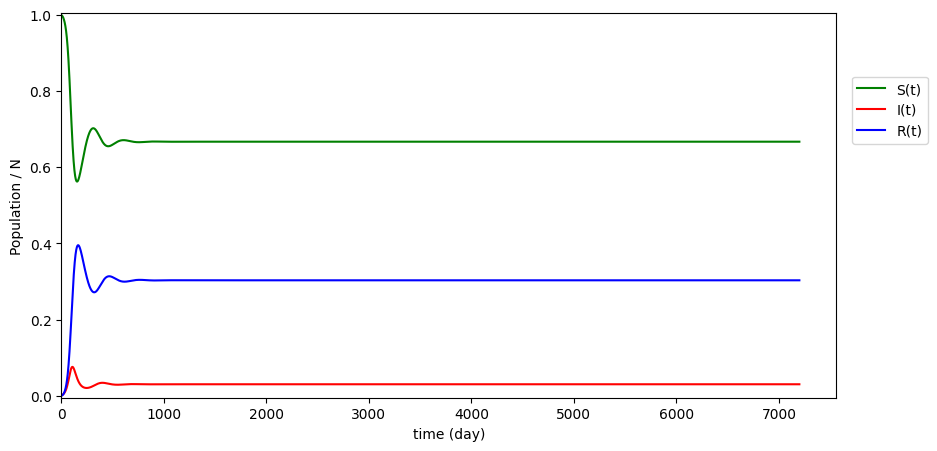

In [50]:
initial_conditions_ODE = [0.999,0.001,0 ,h_thr , h_thr] ###[S(0),I(0),R(0), h(0),h'(0)]

def ODE_SIRSm(sirh_primeh, time, beta = 0.5, gamma = 0.1 , nu = 0.01,tau = 25,m_max = 0.7 , h_th = pow(10,-3), epsilon = 1/4000 ,a_GAMMA =0 , w_GAMMA = 2*np.pi/360 ):
    susceptible, infected , recovered ,h , h_prime = sirh_primeh
    GAMMA = 1
    m = m_max - (m_max/h_th * epsilon * np.log10(1+np.exp(1/epsilon*(h_th - h))))
    dsirh_primehdt = [-beta *(1-m) * GAMMA * susceptible * infected + nu * recovered,
              beta *(1-m) * GAMMA * susceptible * infected -  gamma * infected,
              gamma * infected - nu * recovered,
              1/tau * (h_prime - h),
              1/tau * (infected - h_prime),]
    return dsirh_primehdt
############# Performance check #######################
Run_time = []
for i in range(100):
  start_time = TimeLib.time()
  solution = odeint(ODE_SIRSm, initial_conditions_ODE, time, args=(beta, gamma , nu,tau,m_max,h_thr,epsilon  ,a_GAMMA  , w_GAMMA  ))
  end_time = TimeLib.time()
  Run_time.append(end_time - start_time)
print(f"Run time: {np.mean(Run_time)}+- {np.std(Run_time)} seconds")

#################plotting###########################
fig, ax = plt.subplots(1,1,figsize = (10,5))
ax.plot(time, solution[:, 0], 'g', label='S(t)')
ax.plot(time, solution[:, 1], 'r', label='I(t)')
ax.plot(time, solution[:, 2], 'b', label='R(t)')


ax.legend(loc=(1.02,0.66))
ax.set_xlabel('time (day)')
ax.set_ylabel('Population / N')
ax.set_ylim(-0.005 ,1.005)
ax.set_xlim(-0.001 ,)

##2.c) Exploring the parameter space
Befor exploring in the parameter space, we plot the endemic state of SIRSm model for 4 different sets of $(m_{max}, \tau)$ and plot the results. As it is demonstrated, the qualitative behaivoir of the endemic state could vary between haveing a fixed point and oscillations.

Text(0.5, 0, 'time (day)')

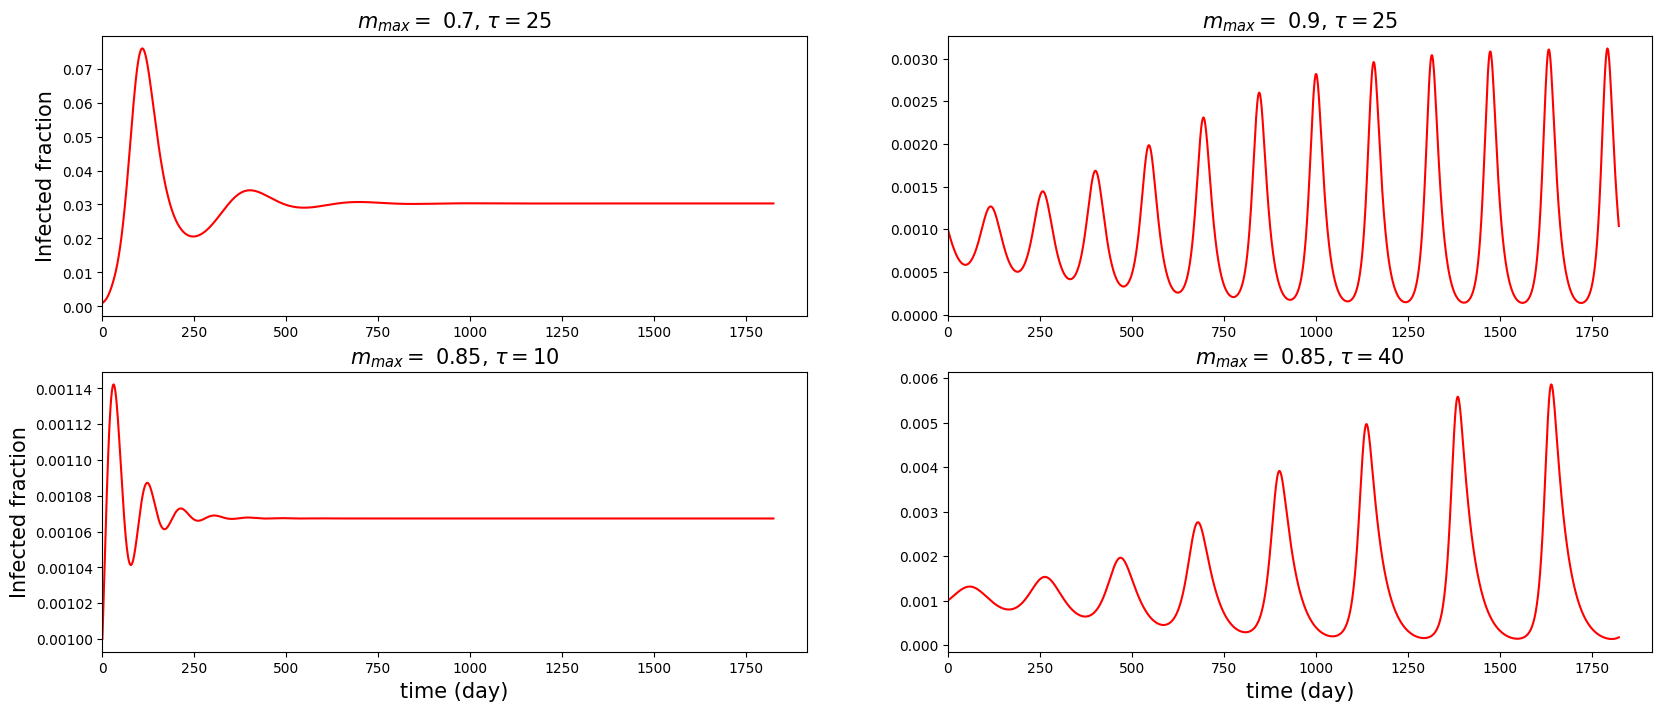

In [55]:
m_max_list= [0.7,0.9]
tau =25
fig, ax = plt.subplots(2,2,figsize = (20,8))
for i in [0,1]:
  M_max_exp = m_max_list[i]
  solution = odeint(ODE_SIRSm, initial_conditions_ODE, time, args=(beta, gamma , nu,tau,M_max_exp,h_thr,epsilon  ,a_GAMMA  , w_GAMMA  ))
  ax[0][i].plot(time, solution[:, 1], 'r', label='I(t)')
  ax[0][i].set_title("$m_{max} = $ "+str(M_max_exp)+r", $\tau = $"+str(tau),fontsize = 15)
  ax[0][i].set_xlim(0.0 ,)

tau_list= [10,40]
m_max = 0.85
for i in [0,1]:
  Tau_exp = tau_list[i]
  solution = odeint(ODE_SIRSm, initial_conditions_ODE, time, args=(beta, gamma , nu,Tau_exp,m_max,h_thr,epsilon  ,a_GAMMA  , w_GAMMA  ))
  ax[1][i].plot(time, solution[:, 1], 'r', label='I(t)')
  ax[1][i].set_title("$m_{max} = $ "+str(m_max)+r", $\tau = $"+str(Tau_exp),fontsize = 15)
  ax[1][i].set_xlim(0.0 ,)


ax[0][0].set_ylabel('Infected fraction',fontsize = 15)
ax[1][0].set_ylabel('Infected fraction',fontsize = 15)

ax[1][1].set_xlabel('time (day)',fontsize = 15)
ax[1][0].set_xlabel('time (day)',fontsize = 15)


### Finding $\tau_{crit}$
Now to find the value of $\tau$ where the endemic state become oscillatory, we need to define a function. The "tau_crit" function, takes all the constants, time and initial conditions and make a loop over the $\tau$ values to find at which value, the endemic state of $I$ has more than 1 peak( which means it has oscillations). If it founds that $\tau_{crit}$, it returns this value, otherwise it returns zero.

In [122]:
####constants
beta = 0.5
gamma = 0.1
nu = 0.01
tau = 25
a_GAMMA = 0
w_GAMMA = 2*np.pi/360
h_thr = pow(10,-3)
m_max = 0.9
epsilon = 1/4000
######initializations
initial_conditions_ODE = [(1-h_thr),h_thr,0 ,h_thr , h_thr]
years = 20
time = np.arange(years*360)
Burn_in_time = 10 * 360
Iterations = 10

In [149]:
def tau_crit(initials , simulation_time,burn_in_time, beta, gamma , nu,m_max,h_thr,epsilon  ,a_GAMMA  , w_GAMMA ):
  for tau in range(1,51):
      solution = odeint(ODE_SIRSm, initials, simulation_time, args=(beta, gamma , nu,tau,m_max,h_thr,epsilon  ,a_GAMMA  , w_GAMMA  ))
      peaks,prop= find_peaks(np.round(solution[burn_in_time:, 1],6))
      if len(peaks) > 1 :
        return tau
  return 0

m_max_list = np.linspace(0.7,1.0,100)

Tau_crit_mean = np.zeros(len(m_max_list))
Tau_crit_err = np.zeros(len(m_max_list))

for i in tqdm(range(len(m_max_list)), desc="Progress", unit="iteration",leave=True):
  m_max_exp = m_max_list[i]
  Tau_c = []
  for iter_num in range(Iterations):
      Tau_c.append(tau_crit(initial_conditions_ODE,time, Burn_in_time,beta, gamma , nu,m_max_exp,h_thr,epsilon  ,a_GAMMA  , w_GAMMA))
  Tau_crit_mean[i] = np.mean(Tau_c)
  Tau_crit_err[i] = np.std(Tau_c)

Progress: 100%|██████████| 100/100 [03:44<00:00,  2.25s/iteration]


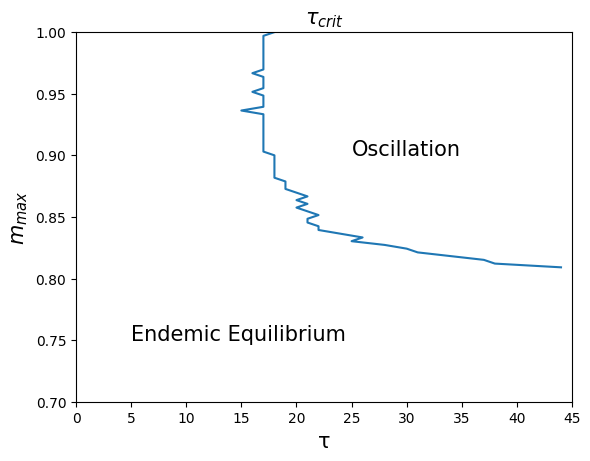

In [152]:
m_filter = m_max_list[Tau_crit_mean>0]
tau_filter = Tau_crit_mean[Tau_crit_mean>0]
tau_filter_err = Tau_crit_err[Tau_crit_mean>0]
##########plotting################
plt.plot(tau_filter,m_filter)
plt.errorbar(tau_filter, m_filter, xerr=10*tau_filter_err,fmt='none')

plt.xlabel('τ',fontsize =15)
plt.ylabel(r'$m_{max}$',fontsize =15)
plt.xlim(0,45)
plt.ylim(0.7,1.0)
plt.title(r"$\tau_{crit}$",fontsize = 15)
plt.text(5,0.75,"Endemic Equilibrium", fontsize = 15)
plt.text(25,0.9,"Oscillation", fontsize = 15)

plt.show()

### Finding number of peaks per year
Instead of just finging the critical value of $\tau$, we can solve the SIRSm model for a range of $m_{max}$ and $\tau$ and count the number of peaks per year. We have plottef the results below.

In [105]:
m_max_list = np.linspace(0.7,1.0,100)
tau_list = np.linspace(1,50,50)


peak_counter = np.zeros((len(m_max_list),len(tau_list)))
for i in tqdm(range(len(m_max_list)), desc="Progress", unit="iteration",leave=True):
  m_max_exp = m_max_list[i]
  for j in range(len(tau_list)):
    tau_exp = tau_list[j]
    N_peaks = []
    for iter_num in range(Iterations):
      solution = odeint(ODE_SIRSm, initial_conditions_ODE, time, args=(beta, gamma , nu,tau_exp,m_max_exp,h_thr,epsilon  ,a_GAMMA  , w_GAMMA  ))
      peaks,prop= find_peaks(np.round(solution[Burn_in_time:, 1],6))
      if len(peaks) == 1 or len(peaks) == 0 :
        N_peaks.append(0)
      else:
        N_peaks.append(360 * (len(peaks)-1)/(peaks[-1] - peaks[0]))
    peak_counter[i][j] = np.mean(N_peaks)

Progress: 100%|██████████| 100/100 [16:28<00:00,  9.88s/iteration]


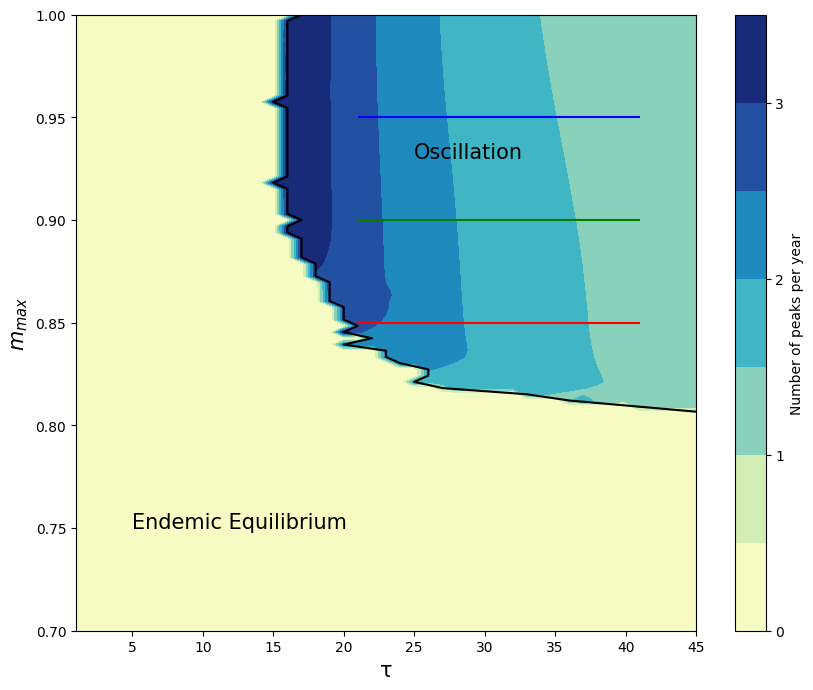

In [148]:
tau_ind = np.where(tau_list >= 21)[0][0]

plt.figure(figsize=(10, 8))
plt.contourf(tau_list, m_max_list, peak_counter, cmap='YlGnBu')


plt.hlines(0.85,tau_list[tau_ind],tau_list[-10],colors = "red")
plt.hlines(0.90,tau_list[tau_ind],tau_list[-10],colors = "green")
plt.hlines(0.95,tau_list[tau_ind],tau_list[-10],colors = "blue")

cbar=plt.colorbar(label = "Number of peaks per year")
cbar.set_ticks([0,1,2,3])
plt.plot(tau_filter,m_filter,c = 'black')
plt.text(5,0.75,"Endemic Equilibrium", fontsize = 15)
plt.text(25,0.93,"Oscillation", fontsize = 15)

plt.xlabel('τ',fontsize =15)
plt.ylabel(r'$m_{max}$',fontsize =15)
plt.xlim(1,45)
plt.show()

### Finding the relation between number of peaks per year and $\tau$
For this purpose, we take 3 values of $m_{max}$ (the horizental lines in the image above) and find the period of the oscillations for different values of $\tau$. Then we fitted a line to each on of them. The results are demonstrated in a plot below. This shows that the period of oscillations grows linearly with the $\tau$.

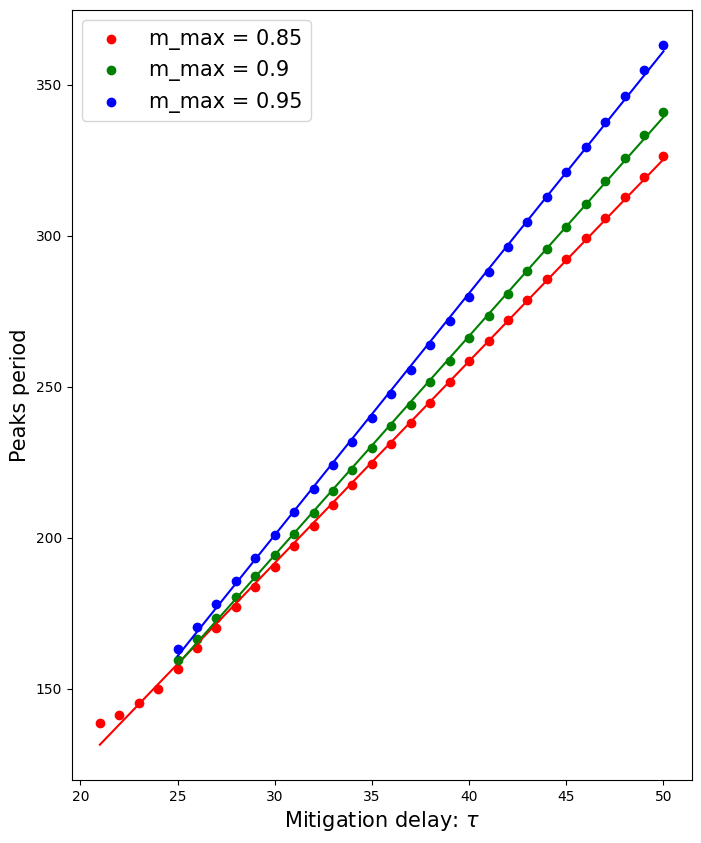

In [135]:
fig, ax = plt.subplots(figsize = (8,10))
##m_max = 0.85
m_ind = np.where(m_max_list >= 0.85)[0][0]

ax.scatter(tau_list[tau_ind:],360/peak_counter[m_ind][tau_ind:],label="m_max = "+str(round(m_max_list[m_ind],2)),c = "red")
a, b = np.polyfit(tau_list[tau_ind:], 360/peak_counter[m_ind][tau_ind:], 1)
ax.plot(tau_list[tau_ind:],b+a*tau_list[tau_ind:],c = "red")

##m_max = 0.90
m_ind = np.where(m_max_list >= 0.90)[0][0]
tau_ind = np.where(tau_list >= 25)[0][0]
ax.scatter(tau_list[tau_ind:],360/peak_counter[m_ind][tau_ind:],label="m_max = "+str(round(m_max_list[m_ind],2)),c = "green")
a, b = np.polyfit(tau_list[tau_ind:], 360/peak_counter[m_ind][tau_ind:], 1)
ax.plot(tau_list[tau_ind:],b+a*tau_list[tau_ind:],c = "green")

##m_max = 0.95
m_ind = np.where(m_max_list >= 0.95)[0][0]
tau_ind = np.where(tau_list >= 25)[0][0]
ax.scatter(tau_list[tau_ind:],360/peak_counter[m_ind][tau_ind:],label="m_max = "+str(round(m_max_list[m_ind],2)),c = "blue")
a, b = np.polyfit(tau_list[tau_ind:], 360/peak_counter[m_ind][tau_ind:], 1)
ax.plot(tau_list[tau_ind:],b+a*tau_list[tau_ind:],c = "blue")

ax.set_xlabel(r"Mitigation delay: $\tau$",fontsize = 15)
ax.set_ylabel("Peaks period",fontsize = 15)
ax.legend(fontsize = 15)

# Problem 3: Complex dynamics in mitigated seasonal diseases
For this problem we need to redefine the constants. Then we define a new function "ODE_SIRSsm" which solves the ODEs for a SIRS model including the mitigation and seasonality.


In [48]:
####constants
beta = 0.5
gamma = 0.1
nu = 0.01
tau = 25
a_GAMMA = 0.25
w_GAMMA = 2*np.pi/360
h_thr = pow(10,-3)
m_max = 0.7
epsilon = 1/4000
######initializations
initial_conditions_ODE = [(1-h_thr),h_thr,0 ,h_thr , h_thr] ###[S(0),I(0),R(0), h(0),h'(0)]
Burn_in_time = 10 * 360
years = 20
time = np.arange(years*360)

In [49]:
def ODE_SIRSsm(sirh_primeh, time, beta = 0.5, gamma = 0.1 , nu = 0.01,tau = 25,m_max = 0.7 , h_th = pow(10,-3), epsilon = 1/4000 ,a_GAMMA =0.25 , w_GAMMA = 2*np.pi/360 ):
    susceptible, infected , recovered ,h , h_prime = sirh_primeh
    GAMMA = 1 + a_GAMMA * np.cos(w_GAMMA*time)
    m = m_max - (m_max/h_th * epsilon * np.log10(1+np.exp(1/epsilon*(h_th - h))))
    dsirh_primehdt = [-beta *(1-m) * GAMMA * susceptible * infected + nu * recovered,
                      beta *(1-m) * GAMMA * susceptible * infected -  gamma * infected,
                      gamma * infected - nu * recovered,
                      1/tau * (h_prime - h),
                1/tau * (infected - h_prime),]
    return dsirh_primehdt

### comparison of SIRSm and SIRSsm
For this comparison, we solve the SIRSm and SIRSsm ODEs for the same set of $m_{max}$ and $\tau$. Then we plot the results for a given timeseries ( after the burn in time), using 4 different parameter sets.


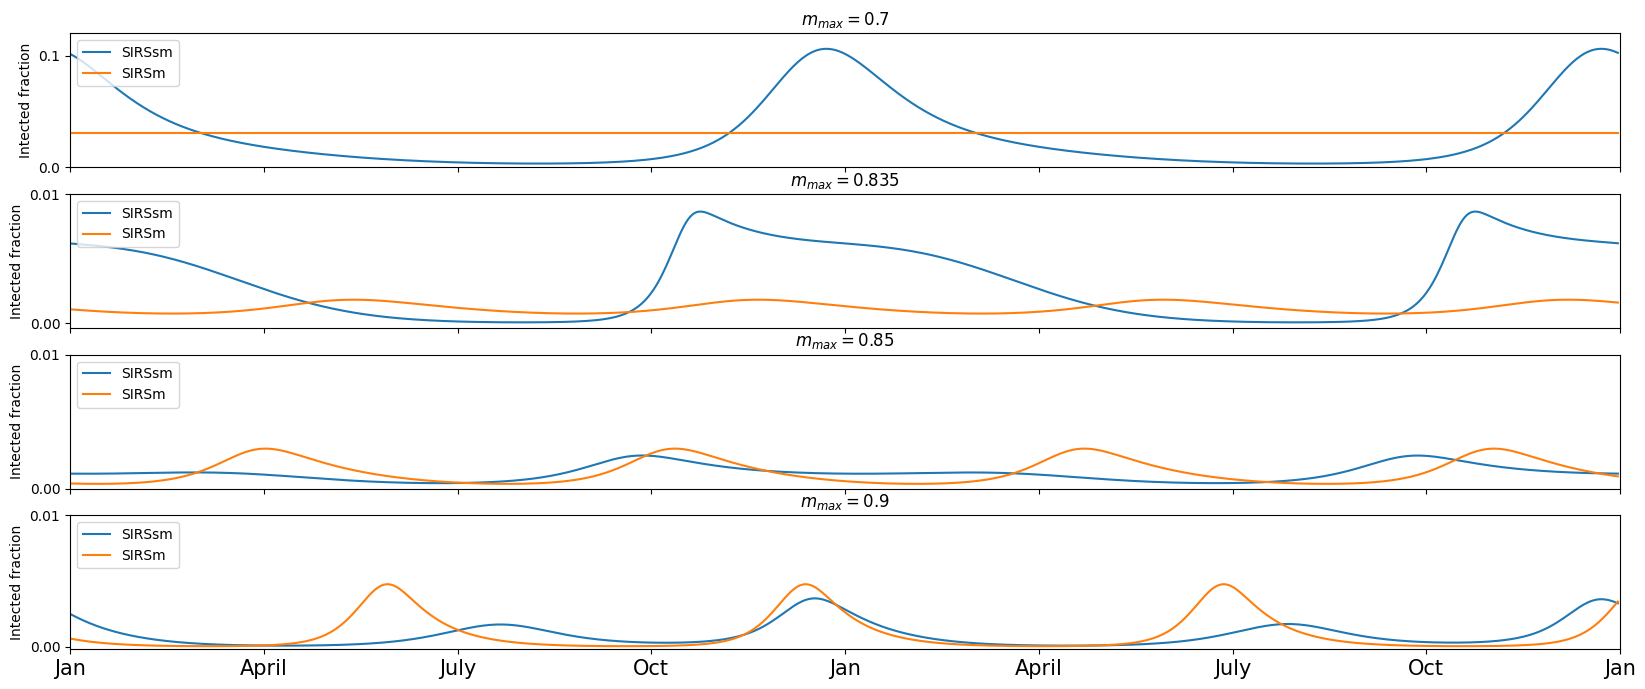

In [51]:
fig, ax = plt.subplots(4,1,figsize = (20,8))
i = 0
m_max_list_1 = [ 0.7, 0.835, 0.85, 0.9]
tau_exp = 30
years = 20
time = np.arange(years*360)
Burn_in_time = 18 * 360
for m_max_exp in m_max_list_1:
    solution_SIRSsm = odeint(ODE_SIRSsm, initial_conditions_ODE, time, args=(beta, gamma , nu,tau_exp,m_max_exp,h_thr,epsilon  ,a_GAMMA  , w_GAMMA  ))
    t_year = time[Burn_in_time:]/360
    ax[i].plot(t_year , solution_SIRSsm[Burn_in_time:,1],label = "SIRSsm")

    solution_SIRSm =  odeint(ODE_SIRSm, initial_conditions_ODE, time, args=(beta, gamma , nu,tau_exp,m_max_exp,h_thr,epsilon  ,a_GAMMA  , w_GAMMA  ))
    ax[i].plot(t_year , solution_SIRSm[Burn_in_time:,1],label = "SIRSm")
    ax[i].legend(loc="upper left")
    ax[i].set_title(r"$m_{max} = $"+str(m_max_exp))
    ax[i].set_xticklabels([],fontsize =15)

    ax[i].set_xlim(18,20)
    ax[i].set_yticks([0.0,0.01])
    ax[i].set_ylabel("Intected fraction")
    i += 1

ax[0].set_ylim(0,0.12)
ax[0].set_yticks([0.0,0.10])
ax[3].set_xticks(18 + np.array([0,3/12,6/12,9/12,1,1+3/12,1+6/12,1+9/12,1+1]))
ax[3].set_xticklabels(["Jan","April","July","Oct","Jan","April","July","Oct","Jan"],fontsize =15)
plt.show()

### Peak diagram
To show the change in the qualitative behavior of the SIRSsm model by changing only one parameter ($m_{max}$ or $\tau$), we plot the peak heights after the burn-in-time. As we can see by changing the parameter, the system goes through period-doubling cascades and even chaos.   

Text(0, 0.5, 'Infected fraction (%)')

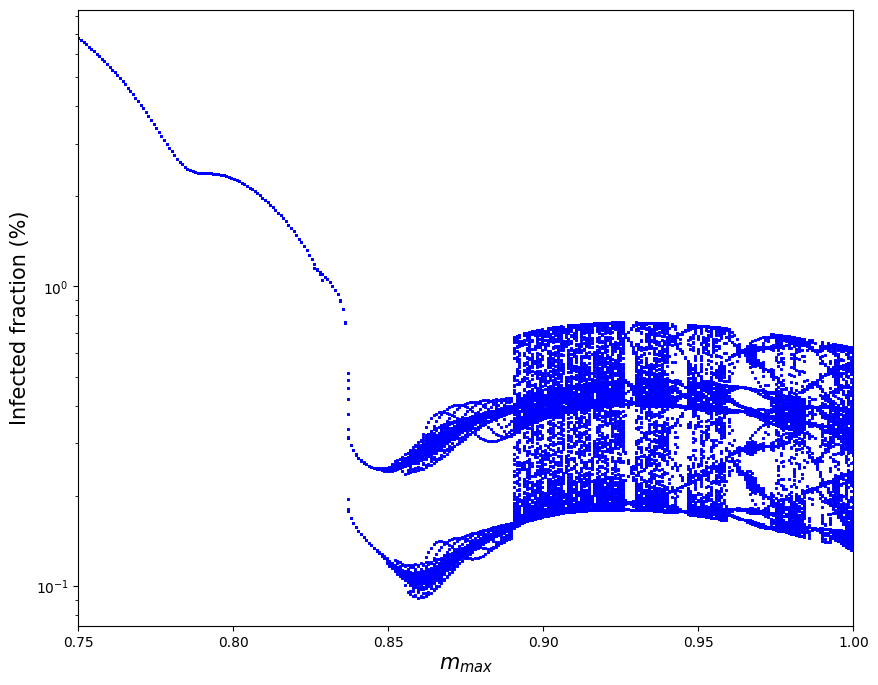

In [24]:
years = 100
time = np.arange(years*360)
Burn_in_time = 10 * 360

tau = 30
m_max_list = np.linspace(0.75,1.0,300)
Iterations = 10
#############################################################
Peak_list = []
for i in tqdm(range(len(m_max_list)), desc="Progress", unit="iteration",leave=True):
  m_max_exp = m_max_list[i]
  Peak_list.append([])
  for iter_num in range(Iterations):
      solution = odeint(ODE_SIRSsm, initial_conditions_ODE, time, args=(beta, gamma , nu,tau,m_max_exp,h_thr,epsilon  ,a_GAMMA  , w_GAMMA  ))
      peaks,prop= find_peaks(np.round(solution[Burn_in_time:, 1],6))
      for ind in peaks:
        Peak_list[-1].append(solution[Burn_in_time+ind,1])

fig, ax = plt.subplots(1,1,figsize = (10,8))
for i in range(len(m_max_list)):
  ax.scatter([m_max_list[i] for q in range(len(Peak_list[i]))],100*np.array(Peak_list[i]),s=0.5,c="blue")
ax.set_yscale("log")
ax.set_xlim(np.min(m_max_list),np.max(m_max_list))
ax.set_xlabel(r"$m_{max}$",fontsize = 15)
ax.set_ylabel("Infected fraction (%)",fontsize = 15)

Progress: 100%|██████████| 300/300 [11:12<00:00,  2.24s/iteration]


Text(0, 0.5, 'Infected fraction (%)')

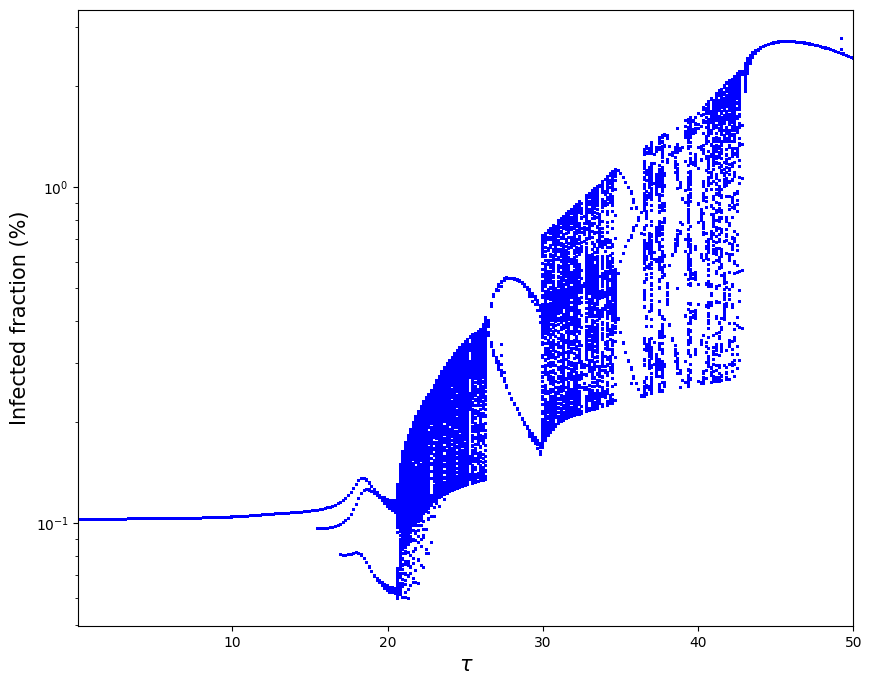

In [28]:
years = 100
time = np.arange(years*360)
Burn_in_time = 10 * 360

m_max = 0.9
tau_list = np.linspace(0.1,50,300)
Iterations = 10
#############################################################
Peak_list = []
for i in tqdm(range(len(m_max_list)), desc="Progress", unit="iteration",leave=True):
  tau_exp = tau_list[i]
  Peak_list.append([])
  for iter_num in range(Iterations):
      solution = odeint(ODE_SIRSsm, initial_conditions_ODE, time, args=(beta, gamma , nu,tau_exp,m_max,h_thr,epsilon  ,a_GAMMA  , w_GAMMA  ))
      peaks,prop= find_peaks(np.round(solution[Burn_in_time:, 1],6))
      for ind in peaks:
        Peak_list[-1].append(solution[Burn_in_time+ind,1])


fig, ax = plt.subplots(1,1,figsize = (10,8))
for i in range(len(tau_list)):
  ax.scatter([tau_list[i] for q in range(len(Peak_list[i]))],100*np.array(Peak_list[i]),s=1,c="blue")
ax.set_yscale("log")
ax.set_xlim(np.min(tau_list),np.max(tau_list))
ax.set_xlabel(r"$\tau$",fontsize = 15)
ax.set_ylabel("Infected fraction (%)",fontsize = 15)

### Arnold tongues diagram

Then we run the "SIRSsm" function for a range of $m_{max}$ and $\tau$ , and calculate the number of peaks per year, the size of these peaks and the mean number of infected ( each of them is averaged over the number of iterations, here 10, for every parameter sets).

In [ ]:
years = 100
time = np.arange(years*360)
Burn_in_time = 10 * 360

m_max_list = np.linspace(0.75,1.0,100)
tau_list = np.linspace(0.1,50,100)
Iterations = 10
#############################################################
peak_counter = np.zeros((len(m_max_list),len(tau_list)))
infected_counter = np.zeros((len(m_max_list),len(tau_list)))
for i in tqdm(range(len(m_max_list)), desc="Progress", unit="iteration",leave=True):
  m_max_exp = m_max_list[i]
  for j in range(len(tau_list)):
    tau_exp = tau_list[j]
    N_peaks = []
    infected_num = []
    for iter_num in range(Iterations):
      solution = odeint(ODE_SIRSsm, initial_conditions_ODE, time, args=(beta, gamma , nu,tau_exp,m_max_exp,h_thr,epsilon  ,a_GAMMA  , w_GAMMA  ))
      peaks,prop= find_peaks(np.round(solution[Burn_in_time:, 1],6))
      if len(peaks) == 1 or len(peaks) == 0 :
        N_peaks.append(0)
      else:
        N_peaks.append(360 * (len(peaks)-1)/(peaks[-1] - peaks[0]))
      infected_num.append(np.mean(solution[Burn_in_time:, 1]))

    peak_counter[i][j] = np.mean(N_peaks)
    infected_counter[i][j] = np.mean(infected_num)

df1 = pd.DataFrame(peak_counter)
df1.to_csv('/content/PeakCounter.csv', index=False, header=False)
df2 = pd.DataFrame(infected_counter)
df2.to_csv('/content/InfectedCounter.csv', index=False, header=False)

#### Reading saved files

In [52]:
file_path = '/content/InfectedCounter.csv'
infected_counter = np.genfromtxt(file_path, delimiter=',')

file_path = '/content/PeakCounter.csv'
peak_counter = np.genfromtxt(file_path, delimiter=',')

#### Plotting Arnold tongues diagram
To plot the Arnold tongues diagram and phase locking, we chose specific number of peaks ("target_values" ) to be shown in different colors and all the other number of peaks in black.

<ipython-input-60-8b0e6529d495>:11: UserWarning: The following kwargs were not used by contour: 'aspect'
  plt.contourf(peak_counter_corrected,extent=[tau_list[0],tau_list[-1],m_max_list[0],m_max_list[-1]], cmap=custom_cmap,aspect = 200,origin="lower")


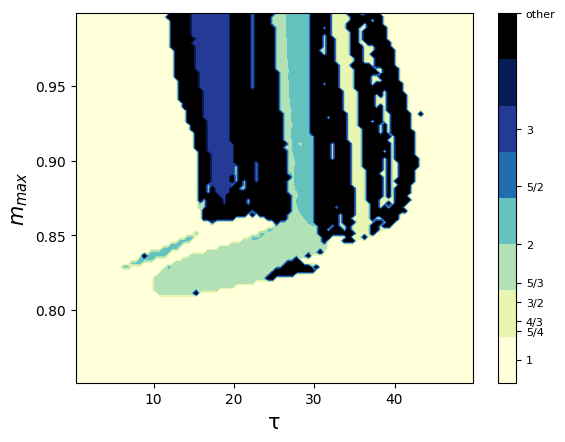

In [60]:
target_values =np.array([1, 5/4, 4/3, 3/2, 5/3, 2, 5/2, 3])

target_mask = np.isin(np.round(peak_counter,2), np.round(target_values,2))
target_mask = np.array(target_mask, dtype=int)
peak_counter_corrected = peak_counter * target_mask
peak_counter_corrected[peak_counter_corrected == 0] = 4
colors = plt.cm.YlGnBu(np.linspace(0, 1, len(target_values)))
colors = np.vstack([colors, [0, 0, 0, 1]])
custom_cmap = ListedColormap(colors)

plt.contourf(peak_counter_corrected,extent=[tau_list[0],tau_list[-1],m_max_list[0],m_max_list[-1]], cmap=custom_cmap,aspect = 200,origin="lower")
cbar=plt.colorbar()
cbar.set_ticks([1, 5/4, 4/3, 3/2, 5/3, 2, 5/2, 3,4])
cbar.set_ticklabels(["1","5/4","4/3","3/2","5/3","2", "5/2", "3","other"],fontsize =8)

plt.xlabel('τ',fontsize =15)
plt.ylabel(r'$m_{max}$',fontsize =15)
plt.show()

#### Plotting average infectious diagram
Here we plot the calculated data for the mean number of infected people per day in the $(m_{max},\tau)$ parameter space.

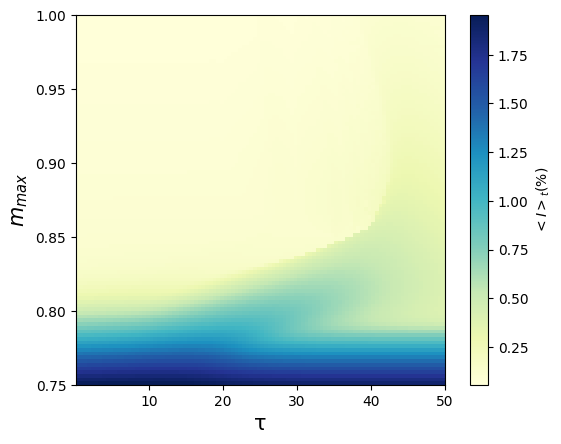

In [61]:
plt.imshow(100*infected_counter,extent=[tau_list[0],tau_list[-1],m_max_list[0],m_max_list[-1]],cmap = 'YlGnBu',aspect = 200,origin="lower")
cbar=plt.colorbar(label = r"$<I>_t (\%)$")

plt.xlabel('τ',fontsize =15)
plt.ylabel(r'$m_{max}$',fontsize =15)
plt.show()

## 3.b)  Largest Lyapunov exponent
For calculating the largest lyapunov exponent(LLE), we add a perturbation to the initial state and run the model for 100 years and calculate the distance between the final states in the perturbed and unperturbed solutions. The LLE is : $λ_1 =
\frac{1}{t_{tot}} log(\frac{|δ(t)|}{δ_0})$ . For each parameter sets we run this simulation for 20 iterations and average over the results. Then we plot the results.

In [73]:
Iterations = 20
years = 100
time = np.arange(years*360)
Burn = 90 * 360

def fit_line(row,burn_in_time = Burn):
    coefficients = np.polyfit(np.arange(len(row))+burn_in_time, row, 1)
    return coefficients[1]

def lyapunov_exponent(initials, time, perturbation=1e-8,iterations = 20,burn_in_time = Burn, beta = 0.5, gamma = 0.1 , nu = 0.01,tau = 25,m_max = 0.7 , h_th = pow(10,-3), epsilon = 1/4000 ,a_GAMMA =0.25 , w_GAMMA = 2*np.pi/360):
    ode_args = (beta, gamma , nu,tau,m_max,h_thr,epsilon  ,a_GAMMA  , w_GAMMA  )
    t_after_burn_in = time[burn_in_time:]

    solution_x = odeint(ODE_SIRSsm, initials, time, args=ode_args)
    solution_x64 = np.array(solution_x[burn_in_time:], dtype=np.float64)

    dx = perturbation/np.sqrt(2) * np.array([-1 , 1 , 0 , 0 ,0])
    x_dx = initials + dx
    perturbed_solutions = np.zeros((iterations,len(t_after_burn_in),5),dtype=np.float64)

    for iter in range(iterations):
        solution_x_dx = odeint(ODE_SIRSsm, x_dx, time, args=ode_args)
        perturbed_solutions[iter] = np.array(solution_x_dx[burn_in_time:], dtype=np.float64)

    dy = np.linalg.norm(solution_x64 - perturbed_solutions,axis = 2)
    log_dy_dx = np.log(dy/perturbation)
    lyap_exp_list = 360 * log_dy_dx.T/t_after_burn_in[:, np.newaxis]
    max_lyap_exp_list = np.apply_along_axis(fit_line, axis=1, arr=lyap_exp_list.T)
    return np.mean(max_lyap_exp_list), np.std(max_lyap_exp_list)

In [ ]:
m_max_list = np.linspace(0.8,0.9,100)
tau_list = np.linspace(20,45,100)
Iterations = 20
years = 100
time = np.arange(years*360)
Burn = 90 * 360

LLE_list = np.zeros((len(m_max_list), len(tau_list)))

for i in tqdm(range(len(m_max_list)), desc="Progress", unit="iteration",leave=True):
    for j in range(len(tau_list)):
        LLE_list[i][j],LLE_std_err = lyapunov_exponent(initial_conditions_ODE, time,perturbation=1e-8,iterations = Iterations,burn_in_time = Burn, beta = 0.5, gamma = 0.1 , nu = 0.01,tau = tau_list[j],m_max = m_max_list[i] , h_th = pow(10,-3), epsilon = 1/4000 ,a_GAMMA =0.25 , w_GAMMA = 2*np.pi/360)
df4 = pd.DataFrame(LLE_list)
df4.to_csv('/content/LLE.csv', index=False, header=False)

Text(0, 0.5, 'Max mitigation: $m_{max}$')

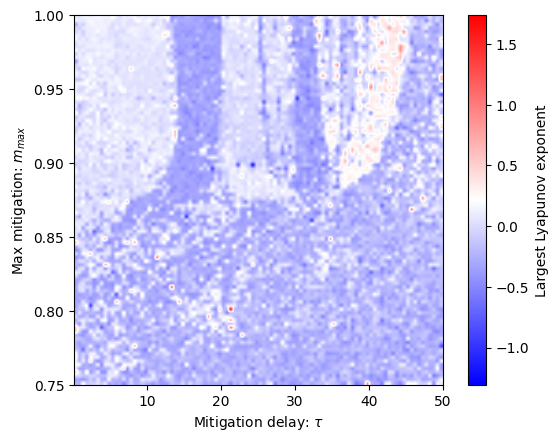

In [71]:
file_path = 'LLE.csv'
LLE_list = np.genfromtxt(file_path, delimiter=',')
plt.imshow(LLE_list,extent=[tau_list[0],tau_list[-1],m_max_list[0],m_max_list[-1]], cmap="bwr",aspect = 200,origin="lower",interpolation='bilinear')
cbar=plt.colorbar(label = "Largest Lyapunov exponent")

plt.xlabel(r"Mitigation delay: $\tau$")
plt.ylabel(r"Max mitigation: $m_{max}$")

##3.c) Parameter set model solutions
To check for these set of parameters, we use the "lyapunov_exponent" function that we defined above. If the result is positive, then the system is chaotic, otherwise it is not.


In [75]:
Iterations = 20
years = 100
time = np.arange(years*360)
LLE_0,LLE_0_err = lyapunov_exponent(initial_conditions_ODE, time,perturbation=1e-8,iterations = Iterations, beta = 0.5, gamma = 0.1 , nu = 0.01,tau = 25,m_max = 0.7 , h_th = pow(10,-3), epsilon = 1/4000 ,a_GAMMA =0.25 , w_GAMMA = 2*np.pi/360)
if LLE_0 > 0:
  print(f"Largest Lyapunov exponent is positive (λ = {round(LLE_0,4)}+_{LLE_0_err}).\nIt is chaotic!")
else:
  print(f"Largest Lyapunov exponent is negative (λ = {round(LLE_0,4)}+_{LLE_0_err}).\nIt is NOT chaotic!")

Largest Lyapunov exponent is negative (λ = -0.1672+_2.7755575615628914e-17).
It is NOT chaotic!


# Problem 4: Using bootstrapping for error propagation

## 4.a and 4.b) Apply bootstrapping on sample datasets
First we define a function that takes the original data and returns arbitrary number of bootstrapping samples with the same size of data.

In [2]:
def bootstrapping(original_data ,number_of_samples =5000 ):
    return np.array([np.random.choice(original_data, size=len(original_data), replace=True) for sample_num in range(number_of_samples)])

In this part, we generate an artificial set of 100 data points following the normal distribution $N(0, 1)$. Using the above function, we make 5000 samples of size 100 (BS_data) and calculate the mean value for each sample. Then we can plot the histogram of these 5000 mean values to show the probability distribution of the estimate. In addition to that we use the "np.percentile" to find the confidence interval.
The classical solution for the probability distribution of the mean value of 100 points $A$ sampled from normal distribution is $N(mean(A), std(A))$. To check whether the central limit theorem applies to this estimation, we plot the normal distribution with mean = $mean(BS\_data)$ and std = $std(BS\_data)$.

(-4.0, 4.0)

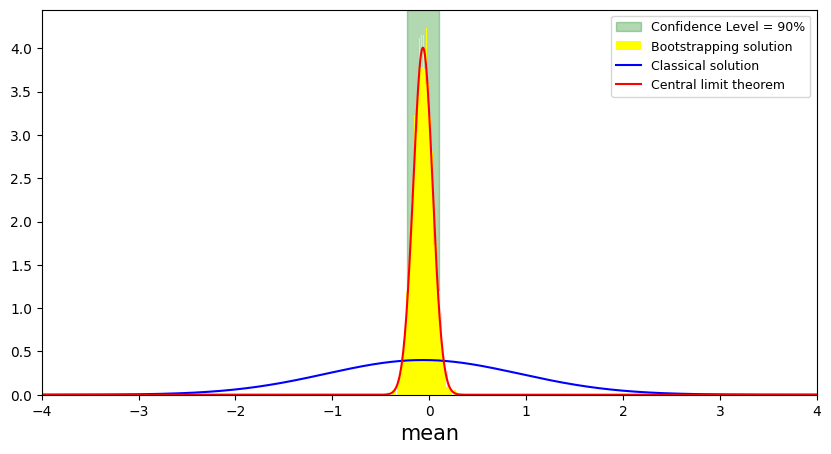

In [46]:
data_points = np.random.normal(0,1,size = 100)
##########Bootstrapping
mean_list1 = np.mean(bootstrapping(data_points),axis= 1)
##########Confiedence level
confidence_level = 90
confidence_interval = np.percentile(mean_list1, [(100-confidence_level)/2 ,confidence_level+(100-confidence_level)/2] )
##########classical solution
classical_mean = np.mean(data_points)
classical_std = np.std(data_points)
mean_values = np.linspace(-4,4,1000)
classical_dist = 1/(np.sqrt(2*np.pi)*classical_std) * np.exp(-(mean_values-classical_mean)**2/(2*classical_std**2))
##########CLT
x1 = np.linspace(-4,4,1000)
est_mean1 = np.mean(mean_list1)
est_std1 = np.std(mean_list1)
CLT1 = 1/(np.sqrt(2*np.pi)*est_std1) * np.exp(-(x1-est_mean1)**2/(2*est_std1**2))


##########plotting################
fig, ax = plt.subplots(1,1,figsize = (10,5))
ax.axvspan(confidence_interval[0], confidence_interval[1], alpha=0.3, color='green', label='Confidence Level = '+str(confidence_level)+"%")
ax.hist(mean_list1,bins = 100,density = True, color = 'yellow',label = "Bootstrapping solution")
ax.plot(mean_values,classical_dist, color = 'blue',label = "Classical solution")
ax.plot(x1,CLT1, color = 'red',label = "Central limit theorem")

ax.legend(fontsize = 9)
ax.set_xlabel("mean",fontsize = 15)
ax.set_xlim(-4,4)

For the next part we do the same but with a different set of original data.

(-4.0, 4.0)

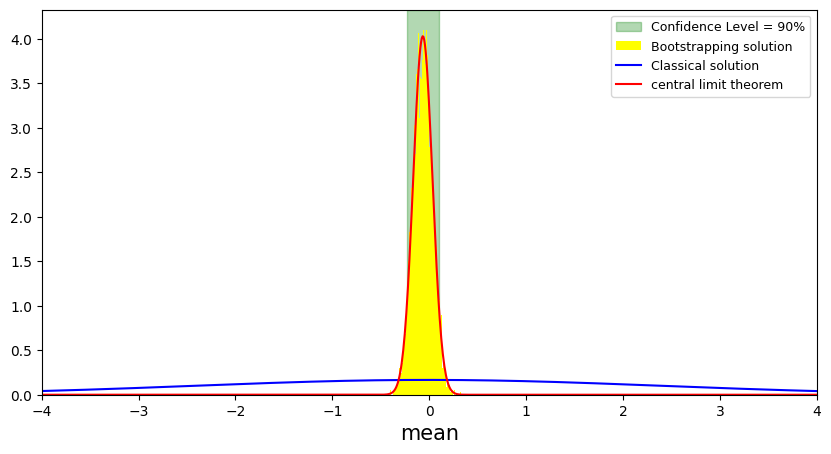

In [47]:
data_points1 = np.random.normal(2,1,size = 100)
data_points2 = np.random.normal(-2,1,size = 100)
bimodal_data_points = np.concatenate((data_points1, data_points2))
##########Bootstrapping
mean_list2= np.mean(bootstrapping(data_points),axis= 1)
##########Confiedence level
confidence_level = 90
confidence_interval = np.percentile(mean_list2, [(100-confidence_level)/2 ,confidence_level+(100-confidence_level)/2] )
##########classical solution
classical_mean = np.mean(bimodal_data_points)
classical_std = np.std(bimodal_data_points)
mean_values = np.linspace(-4,4,1000)
classical_dist = 1/(np.sqrt(2*np.pi)*classical_std) * np.exp(-(mean_values-classical_mean)**2/(2*classical_std**2))
##########CLT
x2 = np.linspace(-4,4,1000)
est_mean2 = np.mean(mean_list2)
est_std2 = np.std(mean_list2)
CLT2 = 1/(np.sqrt(2*np.pi)*est_std2) * np.exp(-(x2-est_mean2)**2/(2*est_std2**2))


########plotting#######
fig, ax = plt.subplots(1,1,figsize = (10,5))
ax.axvspan(confidence_interval[0], confidence_interval[1], alpha=0.3, color='green', label='Confidence Level = '+str(confidence_level)+"%")
ax.hist(mean_list2,bins = 100,density = True, color = 'yellow',label = "Bootstrapping solution")
ax.plot(mean_values,classical_dist, color = 'blue',label = "Classical solution")
ax.plot(x2,CLT2, color = 'red',label = "central limit theorem")

ax.legend(fontsize = 9)
ax.set_xlabel("mean",fontsize = 15)
ax.set_xlim(-4,4)

## 4.c) Use bootstrapping for parameters of the SIRSsm model
First we need to define all the parameters distributions and constants. For each parameter, we draw 1000 samples from the distribution. Next we run the SIRSsm model for each set of parameters ( 1000 different sets) and repeat it for 20 iterations and save the average value of the number of peaks per year and mean number of infeceted per year. For this we only record these variables after the burn_in time ( 10 years).
We also defined "plot_bootstrapping" to plot the results.

In [10]:
#### parameters distributions
parameter_samples = 1000
beta_list = np.random.lognormal(np.log(0.5), 0.2, size= 10 * parameter_samples)
beta_list = beta_list[beta_list>=0][:parameter_samples]
gamma_list = np.random.lognormal(np.log(0.1), 0.2, size= 10 * parameter_samples)
gamma_list = gamma_list[gamma_list>=0][:parameter_samples]
nu_list = 1/np.random.normal(100, 20, size= 10 * parameter_samples)
nu_list = nu_list[nu_list>=0][:parameter_samples]
tau_list = np.random.uniform(20,50, size= 10 * parameter_samples)
tau_list = tau_list[tau_list>=0][:parameter_samples]
m_max_list = np.random.uniform(0.65,0.95, size= 10 * parameter_samples)
m_max_list = m_max_list[m_max_list>=0][:parameter_samples]
h_thr_list = np.random.lognormal(-3, 0.5, size= 10 * parameter_samples)
h_thr_list = h_thr_list[h_thr_list>=0][:parameter_samples]
a_GAMMA_list = np.random.normal(0.25, 0.1, size= 10 * parameter_samples)
a_GAMMA_list = a_GAMMA_list[a_GAMMA_list>=0][:parameter_samples]
w_GAMMA = 2*np.pi/360
epsilon = 1/4000
#######################
years = 20
time = np.arange(years*360)
Burn_in_time = 10 * 360
Iterations = 20

In [76]:
def plot_bootstrapping(mean_I_per_year,mean_peaks_per_year, bs_sample_size = 10000 , confidence_level = 90,Bins = 50, original_data_color = "blue", bs_samples_color = "yellow", conf_int_color = "green" ):
    bs_samples_infected = np.mean(bootstrapping(mean_I_per_year,number_of_samples=bs_sample_size),axis = 1)
    bs_samples_peaks = np.mean(bootstrapping(mean_peaks_per_year,number_of_samples=bs_sample_size),axis = 1)
    confidence_interval_I = np.percentile(bs_samples_infected, [(100-confidence_level)/2 ,confidence_level+(100-confidence_level)/2] )
    confidence_interval_peaks = np.percentile(bs_samples_peaks, [(100-confidence_level)/2 ,confidence_level+(100-confidence_level)/2] )

    fig, ax = plt.subplots(1,2,figsize = (20,5))
    ax[0].axvspan(confidence_interval_I[0], confidence_interval_I[1],alpha = 0.3, color=conf_int_color, label='Confidence Level = '+str(confidence_level)+"%")
    ax[0].hist(bs_samples_infected,bins = Bins,alpha = 0.7,density = True,align="mid", color = bs_samples_color,label = "Bootstrapping samples")
    ax[0].legend(loc="upper left",fontsize = 10)
    ax[0].set_xlim(0.01,0.04)
    ax[0].set_xlabel('mean number of infected per day',fontsize = 15)

    ax[1].axvspan(confidence_interval_peaks[0], confidence_interval_peaks[1],alpha = 0.3, color=conf_int_color, label='Confidence Level = '+str(confidence_level)+"%")
    ax[1].hist(bs_samples_peaks,bins = Bins,alpha = 0.7,density = True,align="mid", color = bs_samples_color,label = "Bootstrapping samples")
    ax[1].legend(loc="upper left",fontsize = 10)
    ax[1].set_xlim(0,2)
    ax[1].set_xlabel('mean number of peaks per year',fontsize = 15)
    print("Confidence interval for mean number of peaks per year :",round(confidence_interval_peaks[0],10)," to ",round(confidence_interval_peaks[1],10))
    print("Confidence interval for mean number of infected per day :",round(confidence_interval_I[0],10)," to ",round(confidence_interval_I[1],10))

    return

In [12]:
peak_counter0 = np.zeros(parameter_samples)
infected_counter0 = np.zeros(parameter_samples)
for i in tqdm(range(parameter_samples), desc="Progress", unit="iteration",leave=True):
  N_peaks = []
  infected_num = []
  for iter_num in range(Iterations):
      solution = odeint(ODE_SIRSsm, initial_conditions_ODE, time, args=(beta_list[i], gamma_list[i] , nu_list[i],tau_list[i],m_max_list[i],h_thr_list[i],epsilon,a_GAMMA_list[i],w_GAMMA))
      infected_solution = np.round(solution[Burn_in_time:, 1],6)
      peaks,prop= find_peaks(infected_solution)
      if len(peaks) == 1 or len(peaks) == 0 :
        N_peaks.append(0)
      else:
        N_peaks.append(360 * (len(peaks)-1)/(peaks[-1] - peaks[0]))
      infected_num.append(np.mean(infected_solution))
  peak_counter0[i] = np.mean(N_peaks)
  infected_counter0[i] = np.mean(infected_num)

Progress:  20%|█▉        | 196/1000 [03:38<16:51,  1.26s/iteration]<ipython-input-9-aad7616c9a19>:4: RuntimeWarning: overflow encountered in exp
  m = m_max - (m_max/h_th * epsilon * np.log10(1+np.exp(1/epsilon*(h_th - h))))
/usr/local/lib/python3.10/dist-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
Progress: 100%|██████████| 1000/1000 [18:21<00:00,  1.10s/iteration]


Confidence interval for mean number of peaks per year : 1.75431623  to  1.8006142274
Confidence interval for mean number of infected per day : 0.0337850181  to  0.0353751525


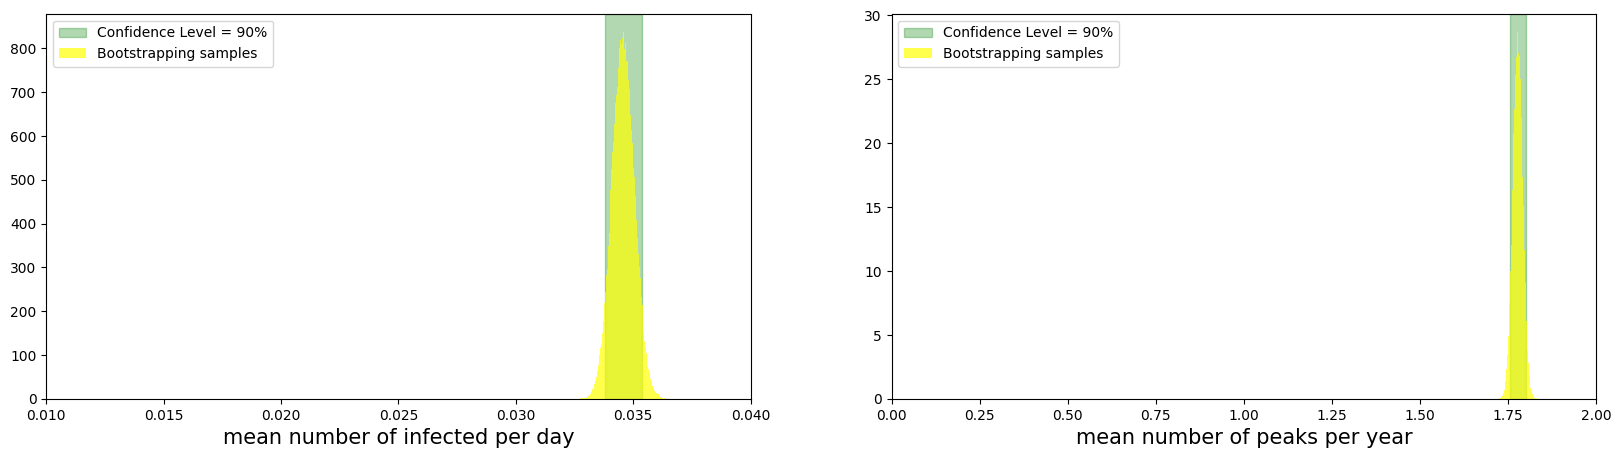

In [77]:
plot_bootstrapping(infected_counter0,peak_counter0, bs_sample_size = 100000 , confidence_level = 90,Bins = 100)

## 4.d) Contributions of different parameters to the overall error
To do this comparison, we can compare the length of the confidence interval. If a parameter, has a bigger impact on a measuring variable, then changing this parameter will results in a wider range of that variable. This means the confidence interval will be wider.


In [26]:
####constants
beta = 0.5
gamma = 0.1
nu = 0.01
tau = 25
a_GAMMA = 0.25
w_GAMMA = 2*np.pi/360
h_thr = pow(10,-3)
m_max = 0.7
epsilon = 1/4000
Burn_in_time = 10 * 360
years = 20
time = np.arange(years*360)
Iterations = 20
parameter_samples = 1000
######initializations
initial_conditions_ODE = [(1-h_thr),h_thr,0 ,h_thr , h_thr] ###[S(0),I(0),R(0), h(0),h'(0)]

### Sampling from $\beta$ parameter

In [27]:
beta_list = np.random.lognormal(np.log(0.5), 0.2, size= 10 * parameter_samples)
beta_list = beta_list[beta_list>=0][:parameter_samples]

peak_counter1 = np.zeros(parameter_samples)
infected_counter1 = np.zeros(parameter_samples)
for i in tqdm(range(parameter_samples), desc="Progress", unit="iteration",leave=True):
  beta_exp = beta_list[i]
  N_peaks = []
  infected_num = []
  for iter_num in range(Iterations):
      solution = odeint(ODE_SIRSsm, initial_conditions_ODE, time, args=(beta_exp, gamma , nu,tau,m_max,h_thr,epsilon,a_GAMMA,w_GAMMA))
      infected_solution = solution[Burn_in_time:, 1]
      peaks,prop= find_peaks(infected_solution)
      if len(peaks) == 1 or len(peaks) == 0 :
        N_peaks.append(0)
      else:
        N_peaks.append(360 * (len(peaks)-1)/(peaks[-1] - peaks[0]))

      infected_num.append(np.mean(infected_solution))
  peak_counter1[i] = np.mean(N_peaks)
  infected_counter1[i] = np.mean(infected_num)

Progress: 100%|██████████| 1000/1000 [13:13<00:00,  1.26iteration/s]


Confidence interval for mean number of peaks per year : 1.0  to  1.0
Confidence interval for mean number of infected per day : 0.0274628122  to  0.0285632396


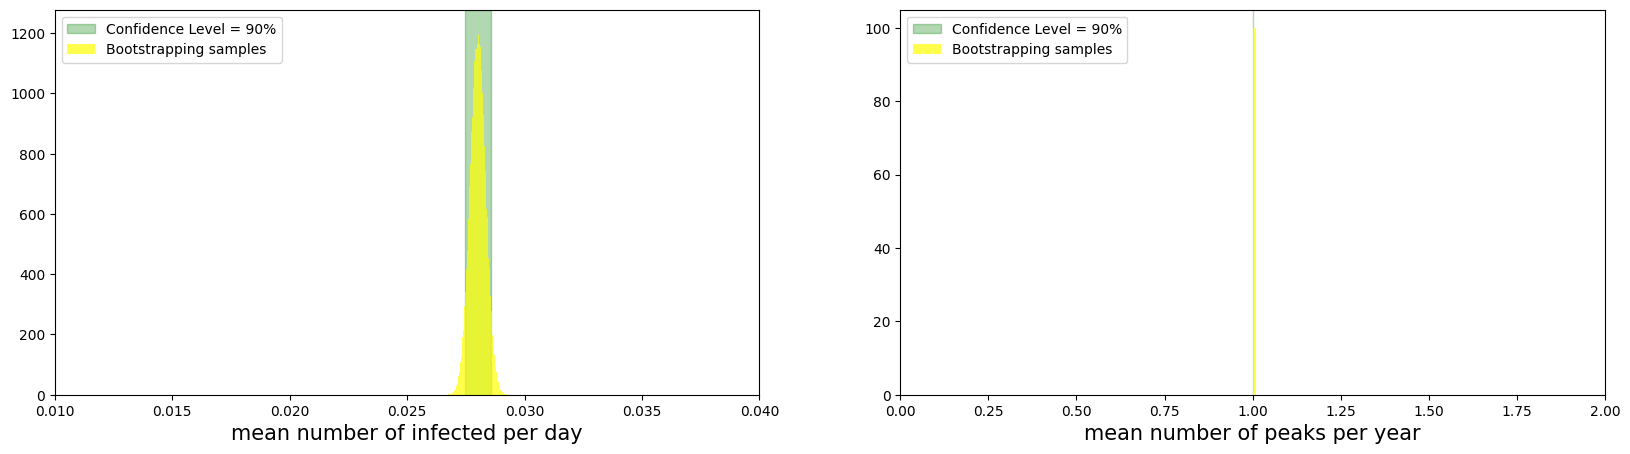

In [36]:
plot_bootstrapping(infected_counter1,peak_counter1, bs_sample_size = 100000 , confidence_level = 90,Bins = 100)

### Sampling from $m_{max}$ parameter

In [37]:
m_max_list = np.random.uniform(0.65,0.95, size= 10 * parameter_samples)
m_max_list = m_max_list[m_max_list>=0][:parameter_samples]

peak_counter2 = np.zeros(parameter_samples)
infected_counter2 = np.zeros(parameter_samples)
for i in tqdm(range(parameter_samples), desc="Progress", unit="iteration",leave=True):
  m_max_exp = m_max_list[i]
  N_peaks = []
  infected_num = []
  for iter_num in range(Iterations):
      solution = odeint(ODE_SIRSsm, initial_conditions_ODE, time, args=(beta, gamma , nu,tau,m_max_exp,h_thr,epsilon,a_GAMMA,w_GAMMA))
      infected_solution = solution[Burn_in_time:, 1]
      peaks,prop= find_peaks(infected_solution)
      if len(peaks) == 1 or len(peaks) == 0 :
        N_peaks.append(0)
      else:
        N_peaks.append(360 * (len(peaks)-1)/(peaks[-1] - peaks[0]))

      infected_num.append(np.mean(infected_solution))
  peak_counter2[i] = np.mean(N_peaks)
  infected_counter2[i] = np.mean(infected_num)

Progress: 100%|██████████| 1000/1000 [13:51<00:00,  1.20iteration/s]


Confidence interval for mean number of peaks per year : 1.4501343162  to  1.5089958755
Confidence interval for mean number of infected per day : 0.0118804314  to  0.0131891497


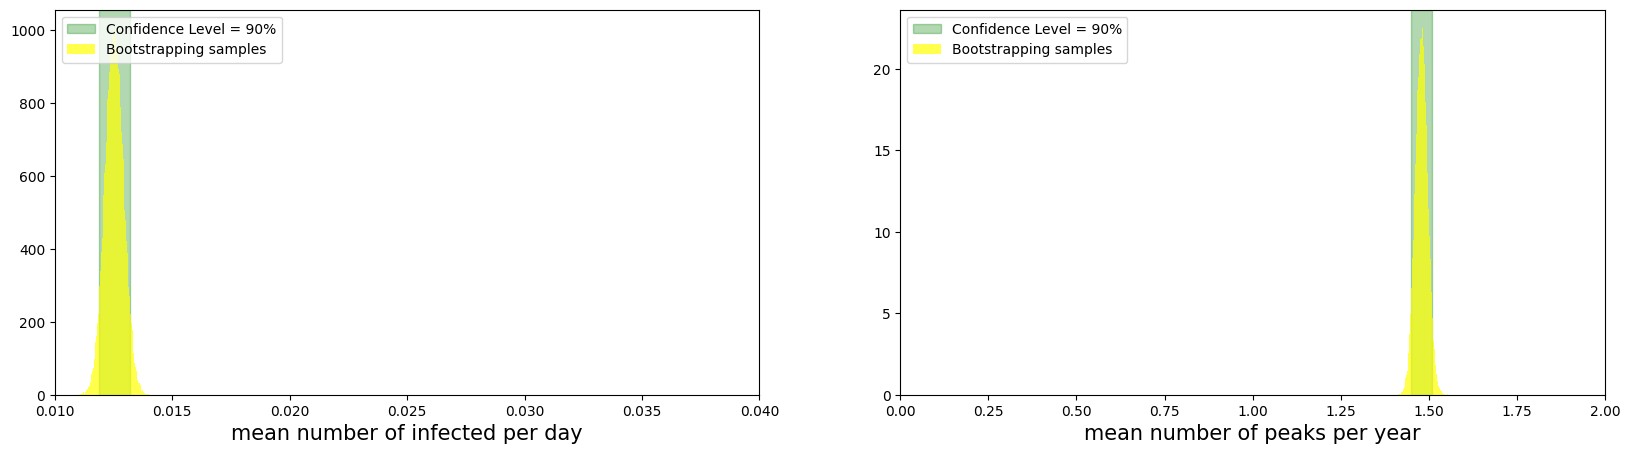

In [38]:
plot_bootstrapping(infected_counter2,peak_counter2, bs_sample_size = 100000 , confidence_level = 90,Bins = 100)

### Sampling from $a_{seasonality}$ parameter

In [43]:
a_GAMMA_list = np.random.normal(0.25, 0.1, size= 10 * parameter_samples)
a_GAMMA_list = a_GAMMA_list[a_GAMMA_list>=0][:parameter_samples]

peak_counter3 = np.zeros(parameter_samples)
infected_counter3 = np.zeros(parameter_samples)
for i in tqdm(range(parameter_samples), desc="Progress", unit="iteration",leave=True):
  a_GAMMA_exp = a_GAMMA_list[i]
  N_peaks = []
  infected_num = []
  for iter_num in range(Iterations):
      solution = odeint(ODE_SIRSsm, initial_conditions_ODE, time, args=(beta, gamma , nu,tau,m_max,h_thr,epsilon,a_GAMMA_exp,w_GAMMA))
      infected_solution = solution[Burn_in_time:, 1]
      peaks,prop= find_peaks(infected_solution)
      if len(peaks) == 1 or len(peaks) == 0 :
        N_peaks.append(0)
      else:
        N_peaks.append(360 * (len(peaks)-1)/(peaks[-1] - peaks[0]))

      infected_num.append(np.mean(infected_solution))
  peak_counter3[i] = np.mean(N_peaks)
  infected_counter3[i] = np.mean(infected_num)

Progress: 100%|██████████| 1000/1000 [13:53<00:00,  1.20iteration/s]


Confidence interval for mean number of peaks per year : 1.0  to  1.0
Confidence interval for mean number of infected per day : 0.0291609394  to  0.0292118959


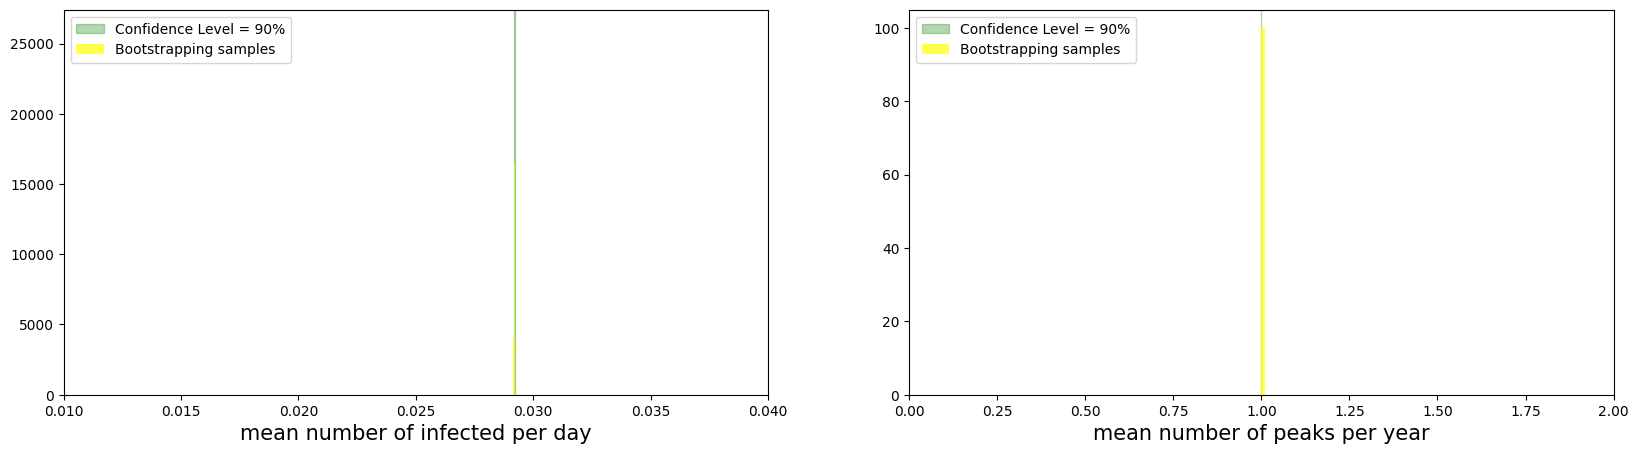

In [44]:
plot_bootstrapping(infected_counter3,peak_counter3, bs_sample_size = 100000 , confidence_level = 90,Bins = 100)